In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import CountVectorizer

<h1> Data Processing Functions </h1>

In [3]:
# functions for processing data

# function which removes all the stop text from the 'text' column
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

# reads in the json file, only to the max entries and returns them as json_array, if max entries is set to 0 then it reads the full thing
def read_partial_json_file(filename, max_entries=0, encoding='utf-8'):
    json_array = []
    with open(filename, 'r', encoding=encoding) as file:
        if max_entries == 0:
            for line in file:
                json_array.append(json.loads(line))
        else:
            for _ in range(max_entries):
                line = file.readline()
                if not line:
                    break
                json_array.append(json.loads(line))
    return json_array

def add_missing_keys(json_array):
    for obj in json_array:
        for key in ['stars', 'useful', 'funny', 'cool', 'text']:
            if key not in obj:
                obj[key] = 0
                print("Key {} not found in json".format(key))
    return json_array

# removes specified keys from json array
def remove_keys(json_array, keys_to_remove):
    for obj in json_array:
        for key in keys_to_remove:
            obj.pop(key, None)
    return json_array

def ConvertJSONFileToDataFrame(filename, max_entries=1000, encoding='utf-8'):
    #load in the json array
    json_array = read_partial_json_file(filename, max_entries, encoding)
    #add in the missing keys, will set to 0 for now but a heuristic for this will have to be made.
    json_array = add_missing_keys(json_array)
    df = pd.DataFrame(json_array)
    ColumnsToRemove = ['business_id', 'user_id', 'date', 'review_id']
    df = df.drop(columns=ColumnsToRemove)
    return df

def preprocess_dataframe(df, text_column):
    # Apply preprocess_text function to the specified text column in the DataFrame
    df[text_column] = df[text_column].apply(preprocess_text)
    return df


<h2> Experiment Code </h2>

In [ ]:
# code to set all values above 10 to 10
# for column in ['funny', 'cool', 'useful']:
#     # Apply the condition and set values greater than 20 to 20
#     df[column] = df[column].apply(lambda x: min(x, 10))

# code to remove top k words from list.
# Iterate through each 'text' feature
# for column in df.filter(like='text').columns:
#     # Fit and transform the 'text' feature using TfidfVectorizer
#     tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])
#     
#     # Get the feature names (words)
#     feature_names = tfidf_vectorizer.get_feature_names_out()
#     
#     # Get the sum of tfidf scores for each word
#     word_scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
#     
#     # Get the indices of the top 10 most important words
#     top_indices = np.argsort(word_scores)[-50:]
#     
#     # Get the top 10 most important words
#     top_words = [feature_names[idx] for idx in top_indices]
#     # Remove the top 10 most important words from the 'text' feature
#     df[column] = df[column].apply(lambda x: ' '.join(word for word in x.split() if word not in top_words))

This is what makes the test set i use::::

In [112]:
filename = 'yelp_academic_dataset_review.json'
df = ConvertJSONFileToDataFrame(filename, 1000)
df = preprocess_dataframe(df, 'text')

target_columns = ['stars', 'cool', 'funny', 'useful']

X = df['text']
y = df[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


Ignore this next part MLP stuff, still working on it

In [97]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}



mlp_regressor = MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100,),
                              learning_rate='constant', learning_rate_init=0.1, solver='adam',
                              max_iter=200, random_state=42)


tfid = TfidfVectorizer()
X_train_regression = tfid.fit_transform(X_train)
X_test_regression =  tfid.transform(X_test)

column_to_test = 'useful'

# # Train the model
mlp_regressor.fit(X_train_regression, y_train[column_to_test])

# Predictions
y_pred_train = mlp_regressor.predict(X_train_regression)
y_pred_test = mlp_regressor.predict(X_test_regression)

# Evaluate the model
train_mse = mean_squared_error(y_train[column_to_test], y_pred_train)
test_mse = mean_squared_error(y_test[column_to_test], y_pred_test)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 0.026430687859361143
Test MSE: 2.4439752231571203


Below here is also mlp experiment stuff, ignore this too

In [113]:

# Specify ngram_range to extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Specify ngram_range to extract bigrams
X_bigramTest = vectorizer.fit_transform(df['text'])

# Step 3: Split the data into train and test sets
X_train_bigramTest, X_test_bigramTest, y_train_bigramTest, y_test_bigramTest = train_test_split(X_bigramTest, y, test_size=0.2, random_state=42)


mlp_regressor_bigramTest = MLPRegressor(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100,),
                              learning_rate='constant', learning_rate_init=0.1, solver='adam',
                              max_iter=200, random_state=42)


column_to_test = 'useful'

# # Train the model
mlp_regressor_bigramTest.fit(X_train_bigramTest, y_train_bigramTest[column_to_test])

# Predictions

y_pred_test = mlp_regressor_bigramTest.predict(X_test_bigramTest)

# Evaluate the model
test_mse = mean_squared_error(y_test_bigramTest[column_to_test], y_pred_test)

print("Test MSE:", test_mse)

Test MSE: 7.426126638003001


<h2>Parameter Testing Code: SVM</h2>

In [ ]:
# # Standardize features (important for SVM)
# 
# # Create SVM classifier
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('svm', SVC())
# ])
# # Define the grid of parameters to search
# param_grid = {
#     'tfidf__max_features': [1000, 2000, 3000],
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'svm__gamma': ['scale', 'auto', 0.1, 1, 10],
# }
# 
# # Create GridSearchCV object
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
# 
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train['stars'])
# 
# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# 
# # Print the best parameters and best score
# print("Best Parameters:", best_params)
# print("Best Score (Accuracy):", best_score)

<h2> SVM Model Creation </h2>

In [71]:
# Create a pipeline with TF-IDF vectorizer and MultiOutputClassifier with SVM classifier
svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1))
])
# Train the model
svm.fit(X_train, y_train['stars'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svm', SVC(C=1, kernel='linear'))])

In [72]:
# Prediction on test set and report for stars model rating
y_pred = svm.predict(X_test)
label_report_stars = classification_report(y_test['stars'], y_pred,zero_division=1)
print("Classification Report for label", label_report_stars)

Classification Report for label               precision    recall  f1-score   support

         1.0       0.73      0.74      0.73       455
         2.0       0.41      0.28      0.34       303
         3.0       0.41      0.31      0.35       448
         4.0       0.49      0.46      0.47      1003
         5.0       0.72      0.84      0.78      1791

    accuracy                           0.63      4000
   macro avg       0.55      0.52      0.53      4000
weighted avg       0.61      0.63      0.61      4000


<h3> Regression Model: SVR </h3>

In [52]:
tfid = TfidfVectorizer()
X_train_regression = tfid.fit_transform(X_train)
X_test_regression =  tfid.transform(X_test)

In [40]:

# Create SVR model for cool
svr_model_cool = SVR(kernel='rbf', gamma='scale',epsilon=0.1,C=1)  # Radial Basis Function (RBF) kernel is commonly used
# Other kernels you can try: 'linear', 'poly', 'sigmoid'

# Train the model
svr_model_cool.fit(X_train_regression, y_train['cool'])

# Predict on the test set
y_pred = svr_model_cool.predict(X_test_regression)

# Calculate Mean Squared Error (MSE) as a metric
mse = mean_squared_error(y_test['cool'], y_pred)
print("Mean Squared Error:", mse)
# 
# # Calculate R-squared (R2)
# r2 = r2_score(y_test['cool'], y_pred)
# print("R-squared (R2):", r2)

Mean Squared Error: 0.8128874208733926


In [39]:
# Create SVR model for funny
svr_model_f = SVR(kernel='rbf', gamma='scale',epsilon=0.1,C=1)  # Radial Basis Function (RBF) kernel is commonly used
# Other kernels you can try: 'linear', 'poly', 'sigmoid'

# Train the model
svr_model_f.fit(X_train_regression, y_train['funny'])

# Predict on the test set
y_pred = svr_model_f.predict(X_test_regression)

# Calculate Mean Squared Error (MSE) as a metric
mse = mean_squared_error(y_test['funny'], y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.5545578195524139


In [46]:
# Create SVR model for useful
svr_model_u = SVR(kernel='rbf', gamma='scale',epsilon=0.1,C=1)  # Radial Basis Function (RBF) kernel is commonly used
# Other kernels you can try: 'linear', 'poly', 'sigmoid'

# Train the model
svr_model_u.fit(X_train_regression, y_train['useful'])

# Predict on the test set
y_pred = svr_model_u.predict(X_test_regression)

# Calculate Mean Squared Error (MSE) as a metric
mse = mean_squared_error(y_test['useful'], y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 5.318374928536016


<h3>Parameter Testing Code: SVR</h3>

In [86]:
# # Define the parameter grid
# parameters = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'gamma': ['scale', 'auto', 0.1, 1, 10],
#     'epsilon': [0.01, 0.1, 0.5, 1]
# }
# # Create SVR model
# svr_model = SVR()
# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=svr_model, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
# # Fit the grid search to the data
# grid_search.fit(X_train_regression, y_train['cool'])
# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# print(best_params)
# print(best_score)

{'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
-0.9447726515600289


<h3>Frequency Graph Code</h3>

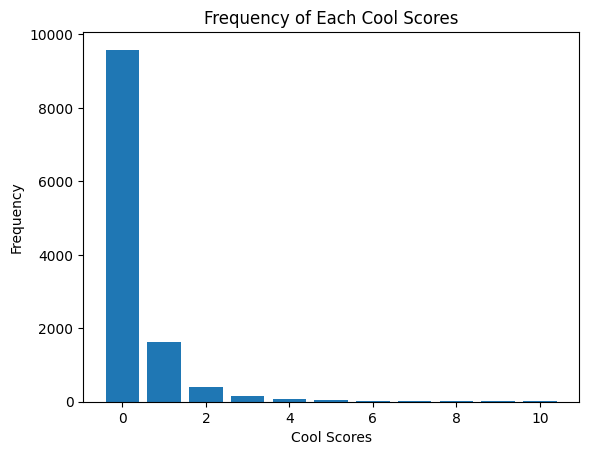

In [43]:
# import matplotlib.pyplot as plt
# 
# values = y_train['cool'].value_counts().sort_index()
# plt.bar(values.index, values.values)
# 
# # # Adding labels and title
# plt.xlabel('Cool Scores')
# plt.ylabel('Frequency')
# plt.title('Frequency of Each Cool Scores')
# # Show plot
# plt.show()